In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import copy

In [2]:
X_train = np.load('/users/mtaranov/NN_all_data/train_set_upperTriangle_noDiag_reads.npy')
y_train = np.load('/users/mtaranov/NN_all_data/labels_train_upperTriangle_noDiag.npy')
X_valid = np.load('/users/mtaranov/NN_all_data/vali_set_upperTriangle_noDiag_reads.npy')
y_valid = np.load('/users/mtaranov/NN_all_data/labels_vali_upperTriangle_noDiag.npy')
X_test = np.load('/users/mtaranov/NN_all_data/test_set_upperTriangle_noDiag_reads.npy')
y_test = np.load('/users/mtaranov/NN_all_data/labels_test_upperTriangle_noDiag.npy')
indx_train = np.load('/users/mtaranov/NN_all_data/indx_train_upperTriangle_noDiag.npy')
indx_valid = np.load('/users/mtaranov/NN_all_data/indx_vali_upperTriangle_noDiag.npy')
indx_test = np.load('/users/mtaranov/NN_all_data/indx_test_upperTriangle_noDiag.npy')                                                                            

In [3]:
X_test.shape

(515972, 11, 2)

In [4]:
y_test.shape

(515972, 1)

In [4]:
def get_pairs_less_than_dist(X, y, indx, thres):
    indx2 = np.where(X[:, 10, 0] - X[:, 10, 1] <= thres)
    return X[indx2], y[indx2], indx[indx2]

In [5]:
def get_pairs_less_than_dist1_more_than_dist2(X, y, indx, thres1, thres2):
    indx2 = np.where((X[:, 10, 0] - X[:, 10, 1] <= thres1) & (X[:, 10, 0] - X[:, 10, 1] >= thres2))
    return X[indx2], y[indx2], indx[indx2]

In [90]:
def print_hist_pos_neg(X_distance_matched, y_distance_matched):
    neg_indxs_distanceMatched = np.where(y_distance_matched==0)[0]
    pos_indxs_distanceMatched = np.where(y_distance_matched==1)[0]
    print 'neg: ', neg_indxs_distanceMatched.shape, 'pos: ', pos_indxs_distanceMatched.shape
    d1=X_distance_matched[pos_indxs_distanceMatched, 10, 0] - X_distance_matched[pos_indxs_distanceMatched, 10, 1]
    d2=X_distance_matched[neg_indxs_distanceMatched, 10, 0] - X_distance_matched[neg_indxs_distanceMatched, 10, 1]
    
    fig, axes = plt.subplots(nrows=2, ncols=1)
    ax0, ax1 = axes.flat

    colors = ['red']
    ax0.hist(d1, color=colors)
    ax0.set_title('pos')

    colors = ['lime']
    ax1.hist(d2, color=colors)
    ax1.set_title('neg')

In [153]:
def get_pairs_distance_matched(X, y, indx, min_dist, max_dist, dist_step, imbalance_ratio):
    
    def subsample_indx(indecies, size, imbalance_ratio):
        indecies_shuffled=copy.copy(indecies)
        np.random.shuffle(indecies_shuffled)
        num_subsampled = size*imbalance_ratio
        if num_subsampled > len(indecies[0]):
            print '    Error: Not enough to subsample'
            exit 
        #print indecies_shuffled[0].shape
        #print indecies_shuffled[0][:num_subsampled].shape
        else:
            return indecies_shuffled[0][:num_subsampled]

    neg_indxs = np.where(y==0)[0]
    pos_indxs = np.where(y==1)[0]
    X_pos=X[pos_indxs]
    X_neg=X[neg_indxs]
    y_pos=y[pos_indxs]
    y_neg=y[neg_indxs]
    indx_pos=indx[pos_indxs]
    indx_neg=indx[neg_indxs]
    
    thres1=dist_step
    thres2=min_dist
    
    X_new=np.empty(([0,X.shape[1],X.shape[2]]))
    y_new=np.empty(([0,y.shape[1]]))
    indx_new=np.empty(([0]))
    
    while thres1 <= max_dist:
        print 'distance window: ', '[', thres2, ',', thres1, ']'
        neg_indx_at_dist=np.where((abs(X_neg[:, 10, 0] - X_neg[:, 10, 1]) <= thres1) & (abs(X_neg[:, 10, 0] - X_neg[:, 10, 1]) >= thres2))
        pos_indx_at_dist=np.where((abs(X_pos[:, 10, 0] - X_pos[:, 10, 1]) <= thres1) & (abs(X_pos[:, 10, 0] - X_pos[:, 10, 1]) >= thres2))

        if len(pos_indx_at_dist[0])> len(neg_indx_at_dist[0]):
            #print 'more pos than neg'
            print 'number of pos at distance=:',  len(pos_indx_at_dist[0])
            print 'number of neg at distance=:',  len(neg_indx_at_dist[0])
            indx_subsampled=subsample_indx(pos_indx_at_dist, len(neg_indx_at_dist[0]), imbalance_ratio)
            new_pos_indx_at_dist=indx_subsampled 
            new_neg_indx_at_dist=neg_indx_at_dist[0]

        else:
            #print 'more neg than pos'
            print 'number of pos at distance=',  len(pos_indx_at_dist[0])
            print 'number of neg at distance=',  len(neg_indx_at_dist[0])
            indx_subsampled=subsample_indx(neg_indx_at_dist, len(pos_indx_at_dist[0]), imbalance_ratio)
            new_pos_indx_at_dist=pos_indx_at_dist[0]
            new_neg_indx_at_dist=indx_subsampled
         
        y_pos_at_dist=y_pos[new_pos_indx_at_dist]
        y_neg_at_dist=y_neg[new_neg_indx_at_dist]
        X_pos_at_dist=X_pos[new_pos_indx_at_dist]
        X_neg_at_dist=X_neg[new_neg_indx_at_dist]

        y_at_dist=np.concatenate((y_pos_at_dist, y_neg_at_dist))
        X_at_dist=np.concatenate((X_pos_at_dist, X_neg_at_dist))
        indx_at_dist=np.concatenate((new_pos_indx_at_dist, new_neg_indx_at_dist))
        print 'labels at dist: ', y_at_dist.shape
        print 'data at dist: ', X_at_dist.shape 
        #print 'indx at dist: ', indx_at_dist.shape

        indx_new=np.concatenate((indx_new, indx_at_dist))
        X_new=np.concatenate((X_new, X_at_dist))
        y_new=np.concatenate((y_new, y_at_dist))
        
        
        #print X_new.shape, X_at_dist.shape
        #print y_new.shape, y_at_dist.shape
        #print indx_new.shape, indx_at_dist.shape
        
        #print "# of neg:", np.where(y_at_dist==0)[0].shape
        #print "# of pos:", np.where(y_at_dist==1)[0].shape
        
        thres2=thres1+min_dist
        thres1=thres1+dist_step
              
    return X_new, y_new, indx_new

In [154]:
min_dist=0
max_dist=5000000
dist_step=10000
class_imbalance=1
X_test_distance_matched, y_test_distance_matched, indx_test_distance_matched = get_pairs_distance_matched(X_test, y_test, indx_test, min_dist, max_dist, dist_step, class_imbalance)
X_train_distance_matched, y_train_distance_matched, indx_train_distance_matched = get_pairs_distance_matched(X_train, y_train, indx_train, min_dist, max_dist, dist_step, class_imbalance)
X_valid_distance_matched, y_valid_distance_matched, indx_valid_distance_matched = get_pairs_distance_matched(X_valid, y_valid, indx_valid, min_dist, max_dist, dist_step, class_imbalance)

distance window:  [ 0 , 10000 ]
number of pos at distance= 15
number of neg at distance= 17
labels at dist:  (30, 1)
data at dist:  (30, 11, 2)
indx at dist:  (30,)
distance window:  [ 10000 , 20000 ]
number of pos at distance=: 75
number of neg at distance=: 10
labels at dist:  (20, 1)
data at dist:  (20, 11, 2)
indx at dist:  (20,)
distance window:  [ 20000 , 30000 ]
number of pos at distance=: 84
number of neg at distance=: 3
labels at dist:  (6, 1)
data at dist:  (6, 11, 2)
indx at dist:  (6,)
distance window:  [ 30000 , 40000 ]
number of pos at distance=: 86
number of neg at distance=: 0
labels at dist:  (0, 1)
data at dist:  (0, 11, 2)
indx at dist:  (0,)
distance window:  [ 40000 , 50000 ]
number of pos at distance=: 79
number of neg at distance=: 0
labels at dist:  (0, 1)
data at dist:  (0, 11, 2)
indx at dist:  (0,)
distance window:  [ 50000 , 60000 ]
number of pos at distance=: 77
number of neg at distance=: 1
labels at dist:  (2, 1)
data at dist:  (2, 11, 2)
indx at dist:  (

In [155]:
print X_test_distance_matched.shape
print X_train_distance_matched.shape
print X_valid_distance_matched.shape

(3058, 11, 2)
(7416, 11, 2)
(4528, 11, 2)


# Train

neg:  (3708,) pos:  (3708,)


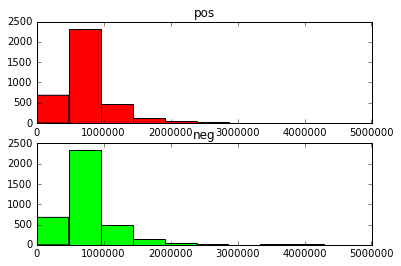

In [156]:
print_hist_pos_neg(X_train_distance_matched, y_train_distance_matched)

# Valid

neg:  (2264,) pos:  (2264,)


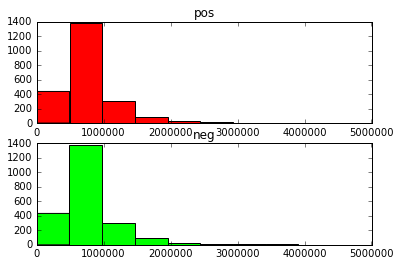

In [157]:
print_hist_pos_neg(X_valid_distance_matched, y_valid_distance_matched)

# Test

neg:  (1529,) pos:  (1529,)


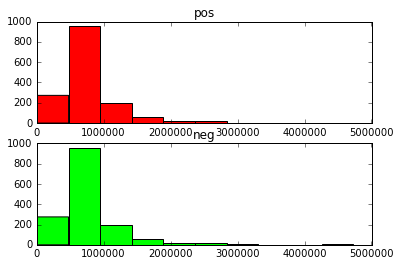

In [158]:
print_hist_pos_neg(X_test_distance_matched, y_test_distance_matched)

In [159]:
# np.save('/users/mtaranov/NN_all_data/less_than_1Mb/distMatched_data_train_set_upperTriangle_noDiag_reads_less_1Mb.npy', X_train_distance_matched)
# np.save('/users/mtaranov/NN_all_data/less_than_1Mb/distMatched_data_vali_set_upperTriangle_noDiag_reads_less_1Mb.npy', X_valid_distance_matched)
# np.save('/users/mtaranov/NN_all_data/less_than_1Mb/distMatched_data_test_set_upperTriangle_noDiag_reads_less_1Mb.npy', X_test_distance_matched)

# np.save('/users/mtaranov/NN_all_data/less_than_1Mb/distMatched_labels_train_upperTriangle_noDiag_reads_less_1Mb.npy', y_train_distance_matched)
# np.save('/users/mtaranov/NN_all_data/less_than_1Mb/distMatched_labels_vali_upperTriangle_noDiag_reads_less_1Mb.npy', y_valid_distance_matched)
# np.save('/users/mtaranov/NN_all_data/less_than_1Mb/distMatched_labels_test_upperTriangle_noDiag_reads_less_1Mb.npy', y_test_distance_matched)

# np.save('/users/mtaranov/NN_all_data/less_than_1Mb/distMatched_indx_train_upperTriangle_noDiag_reads_less_1Mb.npy', indx_train_distance_matched)
# np.save('/users/mtaranov/NN_all_data/less_than_1Mb/distMatched_indx_vali_upperTriangle_noDiag_reads_less_1Mb.npy', indx_valid_distance_matched)
# np.save('/users/mtaranov/NN_all_data/less_than_1Mb/distMatched_indx_test_upperTriangle_noDiag_reads_less_1Mb.npy', indx_test_distance_matched)


In [160]:
# np.save('/users/mtaranov/NN_all_data/less_than_5Mb/distMatched_data_train_set_upperTriangle_noDiag_reads_less_5Mb.npy', X_train_distance_matched)
# np.save('/users/mtaranov/NN_all_data/less_than_5Mb/distMatched_data_vali_set_upperTriangle_noDiag_reads_less_5Mb.npy', X_valid_distance_matched)
# np.save('/users/mtaranov/NN_all_data/less_than_5Mb/distMatched_data_test_set_upperTriangle_noDiag_reads_less_5Mb.npy', X_test_distance_matched)

# np.save('/users/mtaranov/NN_all_data/less_than_5Mb/distMatched_labels_train_upperTriangle_noDiag_reads_less_5Mb.npy', y_train_distance_matched)
# np.save('/users/mtaranov/NN_all_data/less_than_5Mb/distMatched_labels_vali_upperTriangle_noDiag_reads_less_5Mb.npy', y_valid_distance_matched)
# np.save('/users/mtaranov/NN_all_data/less_than_5Mb/distMatched_labels_test_upperTriangle_noDiag_reads_less_5Mb.npy', y_test_distance_matched)

# np.save('/users/mtaranov/NN_all_data/less_than_5Mb/distMatched_indx_train_upperTriangle_noDiag_reads_less_5Mb.npy', indx_train_distance_matched)
# np.save('/users/mtaranov/NN_all_data/less_than_5Mb/distMatched_indx_vali_upperTriangle_noDiag_reads_less_5Mb.npy', indx_valid_distance_matched)
# np.save('/users/mtaranov/NN_all_data/less_than_5Mb/distMatched_indx_test_upperTriangle_noDiag_reads_less_5Mb.npy', indx_test_distance_matched)

In [161]:
# np.save('/users/mtaranov/NN_all_data/less_than_10Mb/distMatched_data_train_set_upperTriangle_noDiag_reads_less_10Mb.npy', X_train_distance_matched)
# np.save('/users/mtaranov/NN_all_data/less_than_10Mb/distMatched_data_vali_set_upperTriangle_noDiag_reads_less_10Mb.npy', X_valid_distance_matched)
# np.save('/users/mtaranov/NN_all_data/less_than_10Mb/distMatched_data_test_set_upperTriangle_noDiag_reads_less_10Mb.npy', X_test_distance_matched)

# np.save('/users/mtaranov/NN_all_data/less_than_10Mb/distMatched_labels_train_upperTriangle_noDiag_reads_less_10Mb.npy', y_train_distance_matched)
# np.save('/users/mtaranov/NN_all_data/less_than_10Mb/distMatched_labels_vali_upperTriangle_noDiag_reads_less_10Mb.npy', y_valid_distance_matched)
# np.save('/users/mtaranov/NN_all_data/less_than_10Mb/distMatched_labels_test_upperTriangle_noDiag_reads_less_10Mb.npy', y_test_distance_matched)

# np.save('/users/mtaranov/NN_all_data/less_than_10Mb/distMatched_indx_train_upperTriangle_noDiag_reads_less_10Mb.npy', indx_train_distance_matched)
# np.save('/users/mtaranov/NN_all_data/less_than_10Mb/distMatched_indx_vali_upperTriangle_noDiag_reads_less_10Mb.npy', indx_valid_distance_matched)
# np.save('/users/mtaranov/NN_all_data/less_than_10Mb/distMatched_indx_test_upperTriangle_noDiag_reads_less_10Mb.npy', indx_test_distance_matched)


In [162]:
# np.save('/users/mtaranov/NN_all_data/less_than_2Mb/distMatched_data_train_set_upperTriangle_noDiag_reads_less_2Mb.npy', X_train_distance_matched)
# np.save('/users/mtaranov/NN_all_data/less_than_2Mb/distMatched_data_vali_set_upperTriangle_noDiag_reads_less_2Mb.npy', X_valid_distance_matched)
# np.save('/users/mtaranov/NN_all_data/less_than_2Mb/distMatched_data_test_set_upperTriangle_noDiag_reads_less_2Mb.npy', X_test_distance_matched)

# np.save('/users/mtaranov/NN_all_data/less_than_2Mb/distMatched_labels_train_upperTriangle_noDiag_reads_less_2Mb.npy', y_train_distance_matched)
# np.save('/users/mtaranov/NN_all_data/less_than_2Mb/distMatched_labels_vali_upperTriangle_noDiag_reads_less_2Mb.npy', y_valid_distance_matched)
# np.save('/users/mtaranov/NN_all_data/less_than_2Mb/distMatched_labels_test_upperTriangle_noDiag_reads_less_2Mb.npy', y_test_distance_matched)

# np.save('/users/mtaranov/NN_all_data/less_than_2Mb/distMatched_indx_train_upperTriangle_noDiag_reads_less_2Mb.npy', indx_train_distance_matched)
# np.save('/users/mtaranov/NN_all_data/less_than_2Mb/distMatched_indx_vali_upperTriangle_noDiag_reads_less_2Mb.npy', indx_valid_distance_matched)
# np.save('/users/mtaranov/NN_all_data/less_than_2Mb/distMatched_indx_test_upperTriangle_noDiag_reads_less_2Mb.npy', indx_test_distance_matched)
